# Try pretrained MobileNetv2

## 2024-07-5


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [ ]:
import tensorflow as tf
import keras

print(tf.__version__)
tf.random.set_seed(42)
keras.backend.clear_session()

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    precision_score,
    f1_score,
)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


def get_confusion_matrix(y_test, y_pred, class_names):

    fig, ax = plt.subplots(figsize=(8, 8))
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
        display_labels=class_names,
    )

    plt.rc("font", size=12)
    ax.set_title(f"Confusion Matrix")

In [ ]:
def plot_history(history, metrics):
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")

In [39]:
path_in = "/home/t.afanasyeva/deep_learning_anaemias/resources/imagestream"

In [40]:
from keras import layers

AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE = 32
IMG_SIZE = (64, 64)

train_ds, test_ds = keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="int",
    class_names=["discocyte", "holly_leaf", "granular", "sickle", "echinocyte"],
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=93,
    validation_split=0.2,
    subset="both",
    data_format="channels_last",
    verbose=True,
)

rescale = tf.keras.Sequential([layers.Rescaling(1.0 / 255)])
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
    ]
)


def prepare(ds, augment=False):

    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

    ds = ds.map(
        lambda x, y: (tf.image.grayscale_to_rgb(x), y), num_parallel_calls=AUTOTUNE
    )

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)


class_names = test_ds.class_names

train_ds = prepare(train_ds, augment=True)
test_ds = prepare(test_ds)

# Verify shapes
for data, label in train_ds.take(1):
    print(f"Train data shape: {data.shape}, label shape: {label.shape}")

Found 14674 files belonging to 5 classes.
Using 11740 files for training.
Using 2934 files for validation.
Train data shape: (32, 64, 64, 3), label shape: (32,)


2024-07-05 19:05:09.538732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
EPOCHS = 200

In [104]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

earlystopper = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)


def learning_rate_schedule(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return (lr * tf.math.exp(-0.1)).numpy()


lr_scheduler = keras.callbacks.LearningRateScheduler(learning_rate_schedule)

In [105]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D

mobile_net = keras.applications.MobileNetV2(
    input_shape=(64, 64, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=5,
    classifier_activation="softmax",
)

model = Sequential()

model.add(mobile_net)
mobile_net.trainable = True

model.add(Dense(1024, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Dense(1024, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

model.add(GlobalAveragePooling2D())
model.add(Dense(5, activation="softmax"))  # Final layer with softmax activation


model.compile(
    optimizer="nadam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

/tmp/ipykernel_966408/832670039.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_net = keras.applications.MobileNetV2(


In [106]:
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_161 (ReLU)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_162 (ReLU)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_163 (ReLU)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

In [90]:
# Calculate the total number of samples
total = len(y_train)

# Calculate the number of samples for each class
class_counts = np.bincount(y_train)
num_classes = len(class_counts)

# Calculate class weights
class_weight = {}
for i in range(num_classes):
    class_weight[i] = (1 / class_counts[i]) * (total / num_classes)

# Print class weights
for i in range(num_classes):
    print("Weight for class {}: {:.2f}".format(i, class_weight[i]))

Weight for class 0: 0.48
Weight for class 1: 2.21
Weight for class 2: 0.67
Weight for class 3: 3.81
Weight for class 4: 1.39


In [108]:
with tf.device("GPU:0"):
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        callbacks=[earlystopper, lr_scheduler],
        epochs=EPOCHS,
    )

Epoch 1/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 47s 58ms/step - accuracy: 0.6114 - loss: 1.0265 - val_accuracy: 0.3579 - val_loss: 6.1908 - learning_rate: 8.1873e-04
Epoch 2/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6083 - loss: 1.1709 - val_accuracy: 0.6742 - val_loss: 0.8608 - learning_rate: 8.1873e-04
Epoch 3/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5991 - loss: 1.0552 - val_accuracy: 0.5031 - val_loss: 1.3938 - learning_rate: 8.1873e-04
Epoch 4/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6316 - loss: 0.9608 - val_accuracy: 0.6868 - val_loss: 0.8188 - learning_rate: 8.1873e-04
Epoch 5/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6295 - loss: 0.9770 - val_accuracy: 0.5099 - val_loss: 1.3410 - learning_rate: 8.1873e-04
Epoch 6/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6212 - loss: 1.0069 - val_accuracy: 0.7696 - val_loss: 0.8590 - learning_rate: 8.1873e-04
Epoch 7/200
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/st

In [109]:
# model.save(
#         "/home/t.afanasyeva/deep_learning_anaemias/model_zoo/mobile_net_v02.keras"
#     )

In [69]:
from sklearn.metrics import classification_report

In [89]:
y_test = tf.concat([y for x, y in test_ds], axis=0)
y_train = tf.concat([y for x, y in train_ds], axis=0)

2024-07-05 20:13:05.997865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-05 20:13:06.607526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [71]:
y_pred = model.predict(test_ds)
y_pred = y_pred.argmax(axis=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


In [75]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   discocyte       0.99      1.00      1.00      1183
  holly_leaf       0.86      0.59      0.70       263
    granular       0.86      0.89      0.88       880
      sickle       0.78      0.93      0.85       162
  echinocyte       0.85      0.87      0.86       446

    accuracy                           0.91      2934
   macro avg       0.87      0.86      0.86      2934
weighted avg       0.91      0.91      0.90      2934



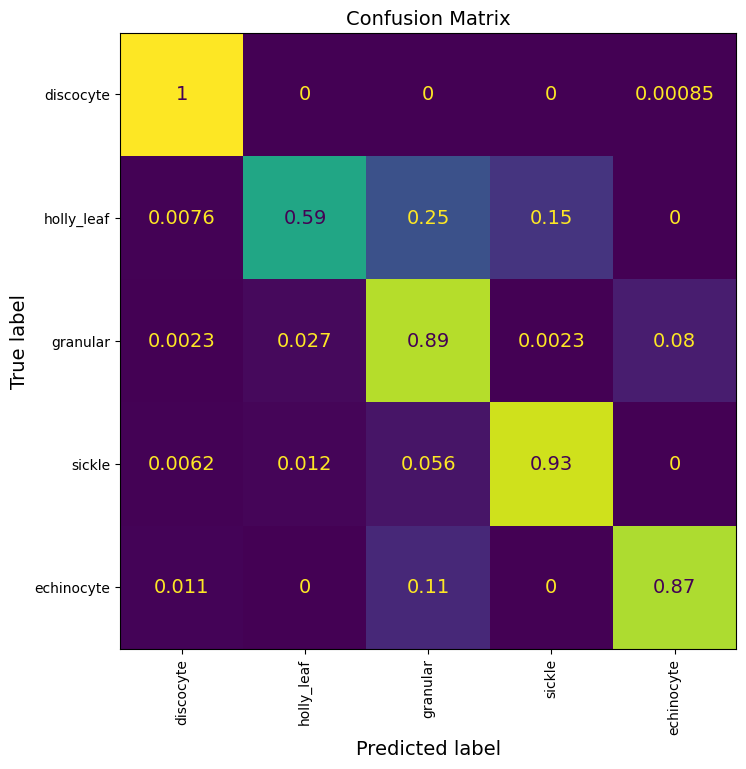

In [77]:
get_confusion_matrix(y_test, y_pred, class_names)

With class weigths, imagenet trained

In [93]:
y_pred = model.predict(test_ds)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step


In [94]:
y_pred = y_pred.argmax(axis=1)

In [95]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   discocyte       0.99      0.92      0.96      1183
  holly_leaf       0.59      0.51      0.55       263
    granular       0.73      0.75      0.74       880
      sickle       0.62      0.72      0.67       162
  echinocyte       0.65      0.75      0.69       446

    accuracy                           0.80      2934
   macro avg       0.72      0.73      0.72      2934
weighted avg       0.81      0.80      0.80      2934



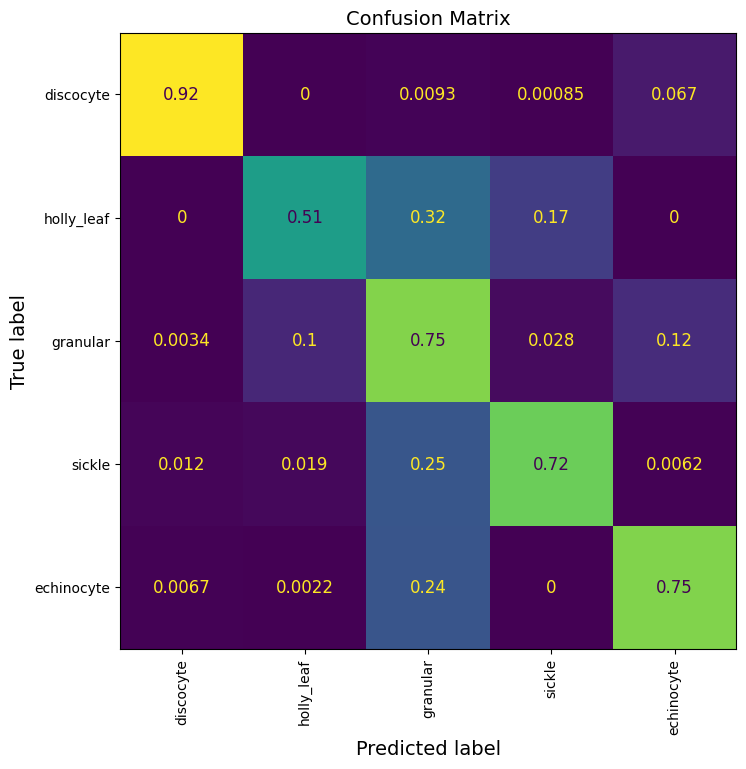

In [96]:
get_confusion_matrix(y_test, y_pred, class_names)

In [99]:
y_pred = model.predict(test_ds)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
              precision    recall  f1-score   support

   discocyte       0.56      1.00      0.72      1183
  holly_leaf       0.39      0.82      0.53       263
    granular       0.62      0.17      0.27       880
      sickle       0.09      0.01      0.01       162
  echinocyte       0.19      0.01      0.03       446

    accuracy                           0.53      2934
   macro avg       0.37      0.40      0.31      2934
weighted avg       0.48      0.53      0.42      2934



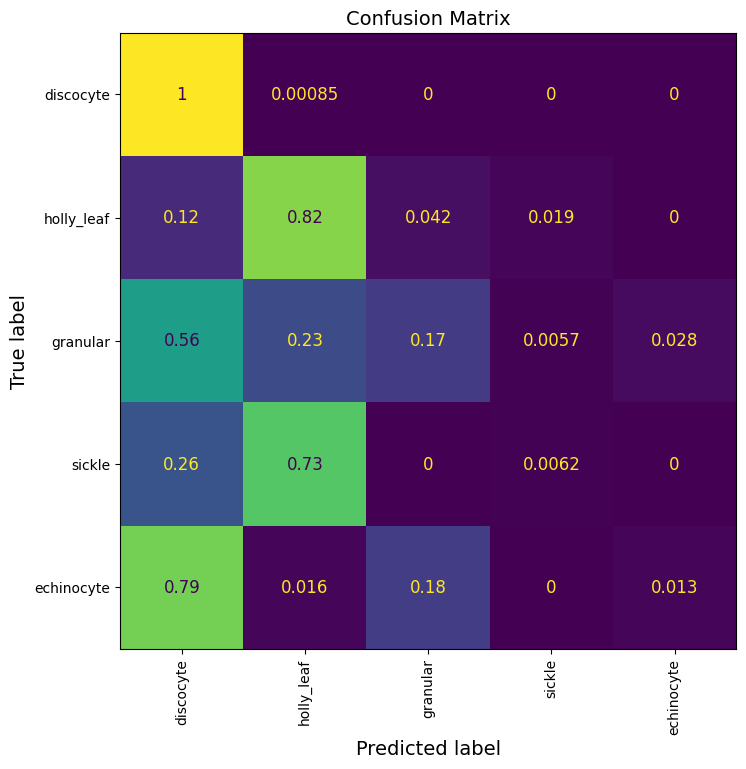

In [100]:
get_confusion_matrix(y_test, y_pred, class_names)